In [4]:
#Regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import rc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMRegressor

#automl
from pycaret.regression import *

In [6]:
path = 'C:/Users/lhsuk/OneDrive - konkuk.ac.kr/바탕 화면/대구 교통사고/dataset'

train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
ss = pd.read_csv(path + '/sample_submission.csv')

train.drop(['ID'],axis=1, inplace=True)
test.drop(['ID'],axis=1, inplace=True)
#external


In [7]:
train.head()

,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,...,상해없음,승용,남,52세,경상,0,0,1,0,3


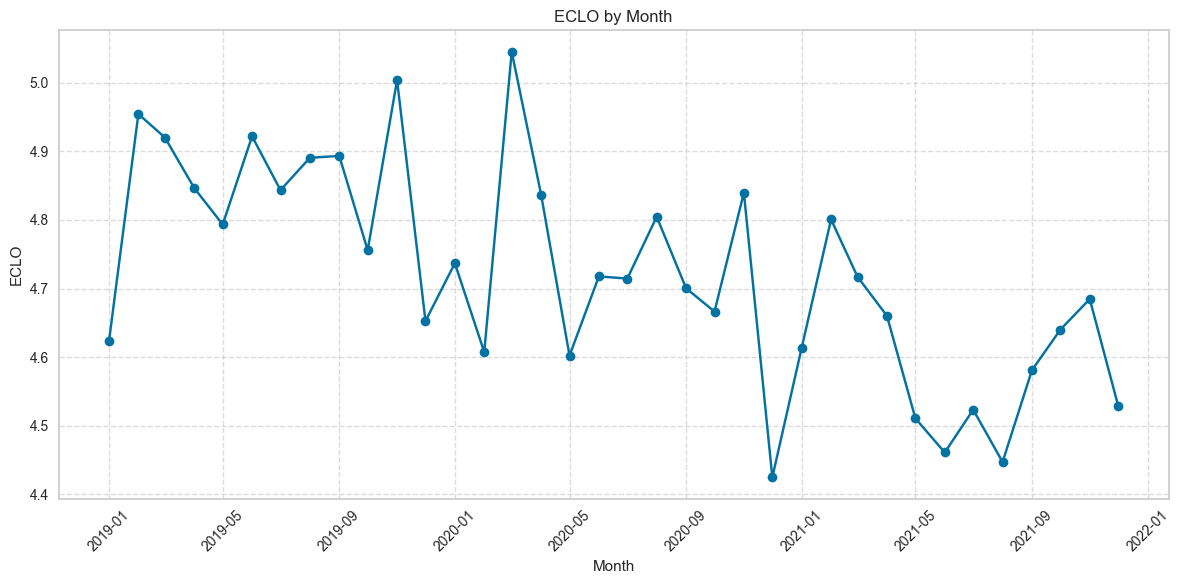

In [11]:
# '사고일시' 열을 datetime 형식으로 변환
train['사고일시'] = pd.to_datetime(train['사고일시'])

# 년월 열 추가
train['년월'] = train['사고일시'].dt.strftime('%y년%m월')

# 년월별 ECLO 평균 계산
monthly_avg = train.groupby('년월')['ECLO'].mean().reset_index()

# 년월을 정렬
monthly_avg['년월'] = pd.to_datetime(monthly_avg['년월'], format='%y년%m월')
monthly_avg = monthly_avg.sort_values('년월')

# 플롯 생성
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg['년월'], monthly_avg['ECLO'], marker='o')

# 축 레이블 및 제목 설정
plt.xlabel('Month')
plt.ylabel('ECLO')
plt.title('ECLO by Month')

# x축 레이블 회전
plt.xticks(rotation=45)

# 그리드 추가
plt.grid(True, linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

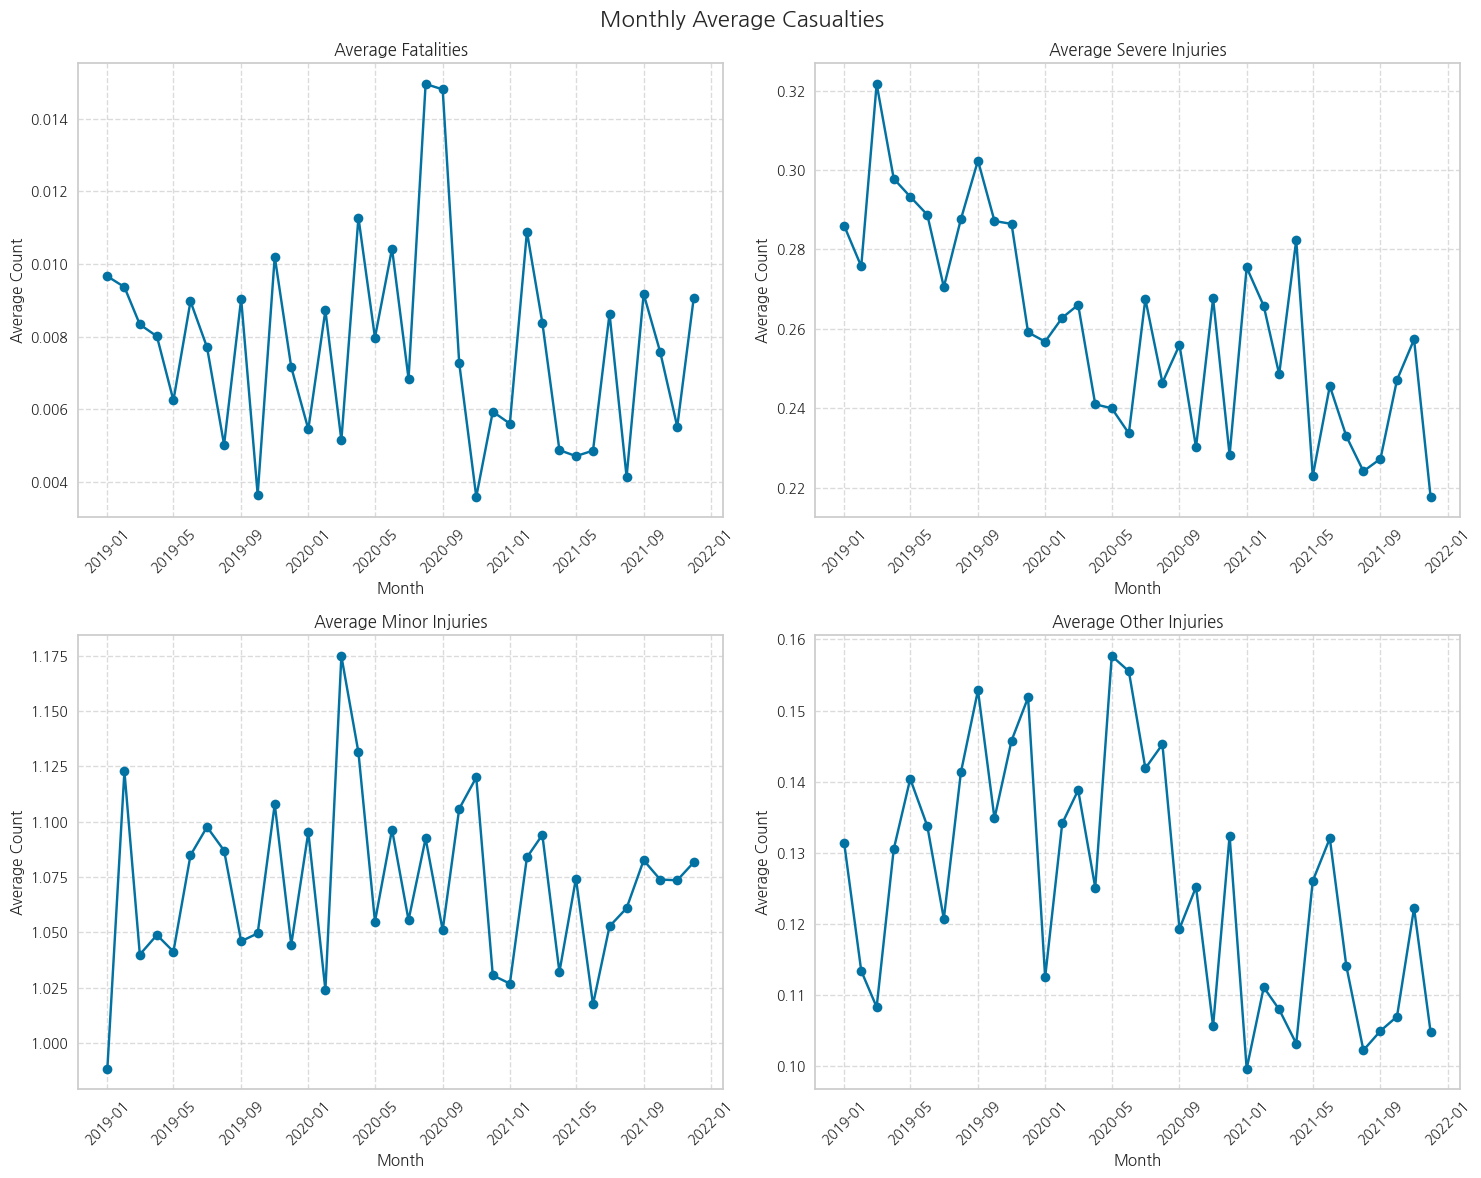


Summary statistics for Average Fatalities:
count    36.000000
mean      0.007754
std       0.002740
min       0.003581
25%       0.005497
50%       0.007839
75%       0.009098
max       0.014965
Name: 사망자수, dtype: float64

Summary statistics for Average Severe Injuries:
count    36.000000
mean      0.261132
std       0.025852
min       0.217742
25%       0.240778
50%       0.260978
75%       0.283279
max       0.321667
Name: 중상자수, dtype: float64

Summary statistics for Average Minor Injuries:
count    36.000000
mean      1.070691
std       0.037152
min       0.988406
25%       1.045640
50%       1.073697
75%       1.094351
max       1.174807
Name: 경상자수, dtype: float64

Summary statistics for Average Other Injuries:
count    36.000000
mean      0.125949
std       0.016970
min       0.099664
25%       0.110417
50%       0.125630
75%       0.139215
max       0.157662
Name: 부상자수, dtype: float64


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

# Assuming 'train' is your DataFrame
df = train

# Convert '사고일시' to datetime if it's not already
df['사고일시'] = pd.to_datetime(df['사고일시'])

# Extract month and year
df['month_year'] = df['사고일시'].dt.to_period('M')

# Group by month and calculate the mean for each category
monthly_data = df.groupby('month_year').agg({
    '사망자수': 'mean',
    '중상자수': 'mean',
    '경상자수': 'mean',
    '부상자수': 'mean'
}).reset_index()

# Convert Period to datetime for plotting
monthly_data['month_year'] = monthly_data['month_year'].dt.to_timestamp()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Monthly Average Casualties', fontsize=16)

# Flatten axs for easier iteration
axs = axs.flatten()

# Categories and their English translations
categories = {
    '사망자수': 'Average Fatalities',
    '중상자수': 'Average Severe Injuries',
    '경상자수': 'Average Minor Injuries',
    '부상자수': 'Average Other Injuries'
}

# Plot each category
for i, (kor, eng) in enumerate(categories.items()):
    axs[i].plot(monthly_data['month_year'], monthly_data[kor], marker='o')
    axs[i].set_title(eng)
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Average Count')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels
    axs[i].tick_params(axis='x', rotation=45)
    
    # Format x-axis to show month and year
    axs[i].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print summary statistics
for category in categories.keys():
    print(f"\nSummary statistics for {categories[category]}:")
    print(monthly_data[category].describe())

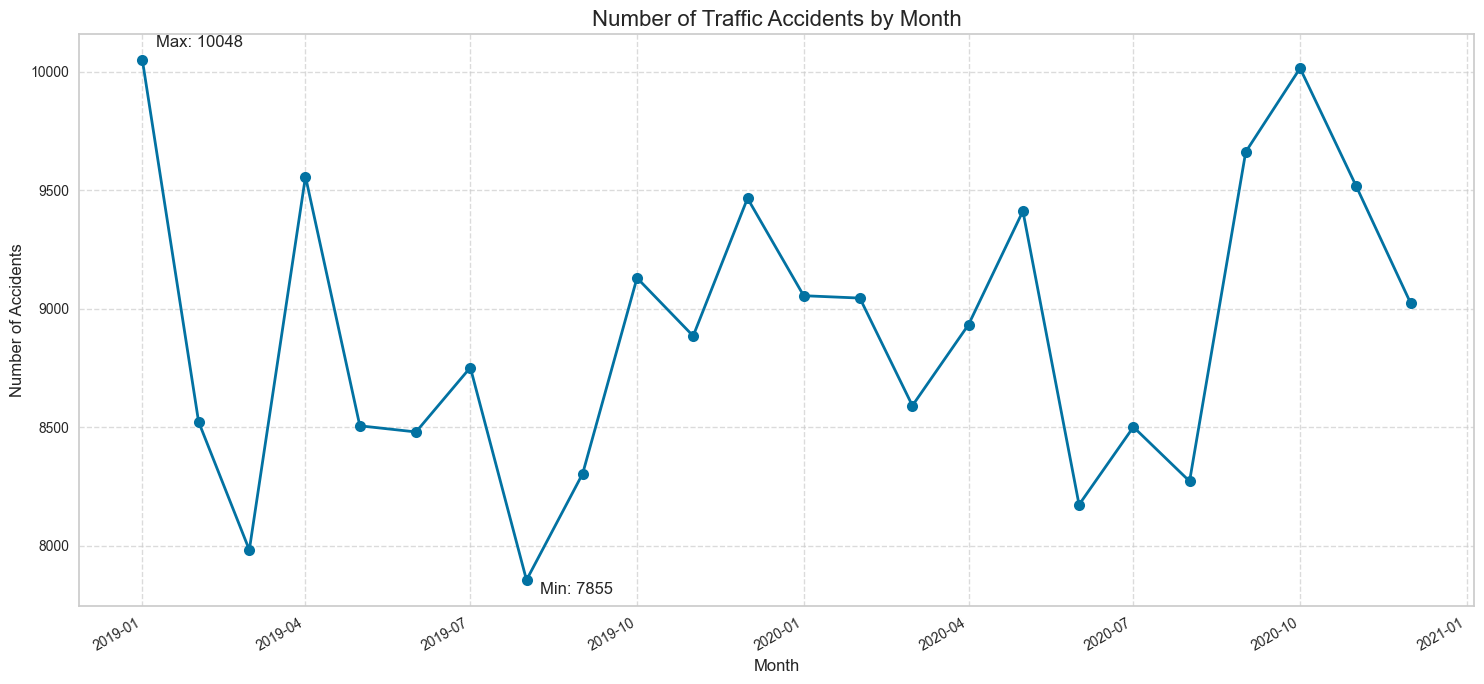

count       24.000000
mean      8903.708333
std        612.033850
min       7855.000000
25%       8495.750000
50%       8909.000000
75%       9425.500000
max      10048.000000
Name: accident_count, dtype: float64


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter, AutoDateLocator

# Sample data creation (replace this with your actual data loading)
date_range = pd.date_range(start='2019-01-01', end='2020-12-31', freq='D')
num_days = len(date_range)

data = {
    '사고일시': date_range,
    '사고ID': range(1, num_days + 1)  # Unique ID for each day
}
df = pd.DataFrame(data)

# Simulate random number of accidents for each day
df['accident_count'] = np.random.randint(100, 500, size=num_days)

# Convert '사고일시' to datetime if it's not already
df['사고일시'] = pd.to_datetime(df['사고일시'])

# Group by month and sum the accident counts
monthly_accidents = df.groupby(df['사고일시'].dt.to_period('M'))['accident_count'].sum().reset_index()
monthly_accidents['사고일시'] = monthly_accidents['사고일시'].dt.to_timestamp()

# Create the plot
plt.figure(figsize=(15, 7))
plt.plot(monthly_accidents['사고일시'], monthly_accidents['accident_count'], marker='o', linestyle='-', linewidth=2, markersize=8)

# Customize the plot
plt.title('Number of Traffic Accidents by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Customize x-axis
plt.gca().xaxis.set_major_locator(AutoDateLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

# Add text annotations for the highest and lowest points
max_point = monthly_accidents.loc[monthly_accidents['accident_count'].idxmax()]
min_point = monthly_accidents.loc[monthly_accidents['accident_count'].idxmin()]

plt.annotate(f'Max: {max_point["accident_count"]}', 
             (max_point['사고일시'], max_point['accident_count']),
             xytext=(10, 10), textcoords='offset points', ha='left')
plt.annotate(f'Min: {min_point["accident_count"]}', 
             (min_point['사고일시'], min_point['accident_count']),
             xytext=(10, -10), textcoords='offset points', ha='left')

# Display the plot
plt.tight_layout()
plt.show()

# Print summary statistics
print(monthly_accidents['accident_count'].describe())

# Note: When using real data, replace the data creation part with:
# df = pd.read_csv('your_data_file.csv')
# df['사고일시'] = pd.to_datetime(df['사고일시'])
# monthly_accidents = df.groupby(df['사고일시'].dt.to_period('M')).size().reset_index(name='accident_count')
# monthly_accidents['사고일시'] = monthly_accidents['사고일시'].dt.to_timestamp()
# Then use 'monthly_accidents' in the plotting code as shown above

In [18]:
country = pd.read_csv('C:/Users/lhsuk/OneDrive - konkuk.ac.kr/바탕 화면/대구 교통사고/dataset/external_open/countrywide_accident.csv')
country.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,COUNTRYWIDE_ACCIDENT_000000,2019-01-01 00,화요일,맑음,서울특별시 강서구 방화동,교차로 - 교차로횡단보도내,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,40세,경상,0,0,1,0,3
1,COUNTRYWIDE_ACCIDENT_000001,2019-01-01 00,화요일,맑음,경기도 포천시 소흘읍,교차로 - 교차로안,건조,차대차,기타,직진우회전진행방해,...,상해없음,이륜,남,20세,경상,0,0,1,0,3
2,COUNTRYWIDE_ACCIDENT_000002,2019-01-01 00,화요일,맑음,경기도 양주시 고암동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,17세,중상,0,1,0,0,5
3,COUNTRYWIDE_ACCIDENT_000003,2019-01-01 00,화요일,맑음,경기도 남양주시 다산동,기타 - 기타,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,10세,중상,0,2,0,0,10
4,COUNTRYWIDE_ACCIDENT_000004,2019-01-01 00,화요일,맑음,인천광역시 부평구 부평동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,승용,남,56세,경상,0,0,2,1,7


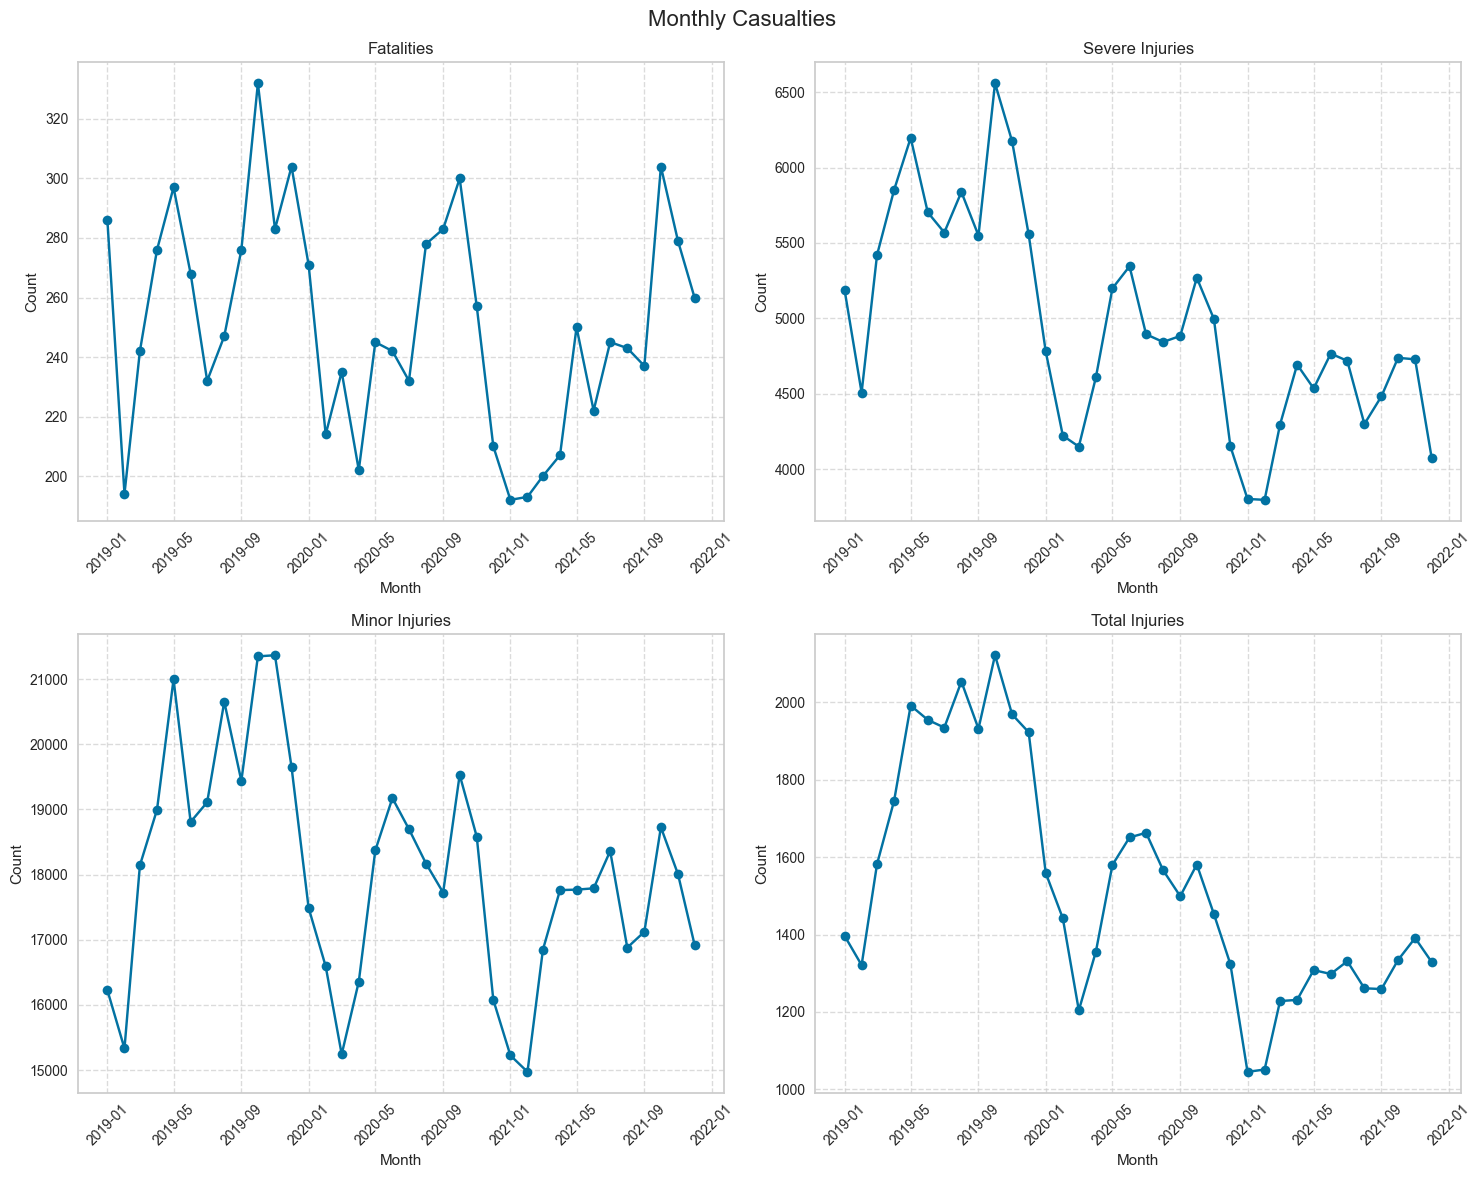

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

df = pd.DataFrame(country)

# Convert '사고일시' to datetime if it's not already
df['사고일시'] = pd.to_datetime(df['사고일시'])

# Extract month and year
df['month_year'] = df['사고일시'].dt.to_period('M')

# Group by month and calculate the sum for each category
monthly_data = df.groupby('month_year').agg({
    '사망자수': 'sum',
    '중상자수': 'sum',
    '경상자수': 'sum',
    '부상자수': 'sum'
}).reset_index()

# Convert Period to datetime for plotting
monthly_data['month_year'] = monthly_data['month_year'].dt.to_timestamp()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Monthly Casualties', fontsize=16)

# Flatten axs for easier iteration
axs = axs.flatten()

# Categories and their English translations
categories = {
    '사망자수': 'Fatalities',
    '중상자수': 'Severe Injuries',
    '경상자수': 'Minor Injuries',
    '부상자수': 'Total Injuries'
}

# Plot each category
for i, (kor, eng) in enumerate(categories.items()):
    axs[i].plot(monthly_data['month_year'], monthly_data[kor], marker='o')
    axs[i].set_title(eng)
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Count')
    axs[i].grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels
    axs[i].tick_params(axis='x', rotation=45)
    
    # Format x-axis to show month and year
    axs[i].xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [12]:
import matplotlib.font_manager as fm
font_path = 'C:/Users/lhsuk/OneDrive - konkuk.ac.kr/바탕 화면/nanum-gothic/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

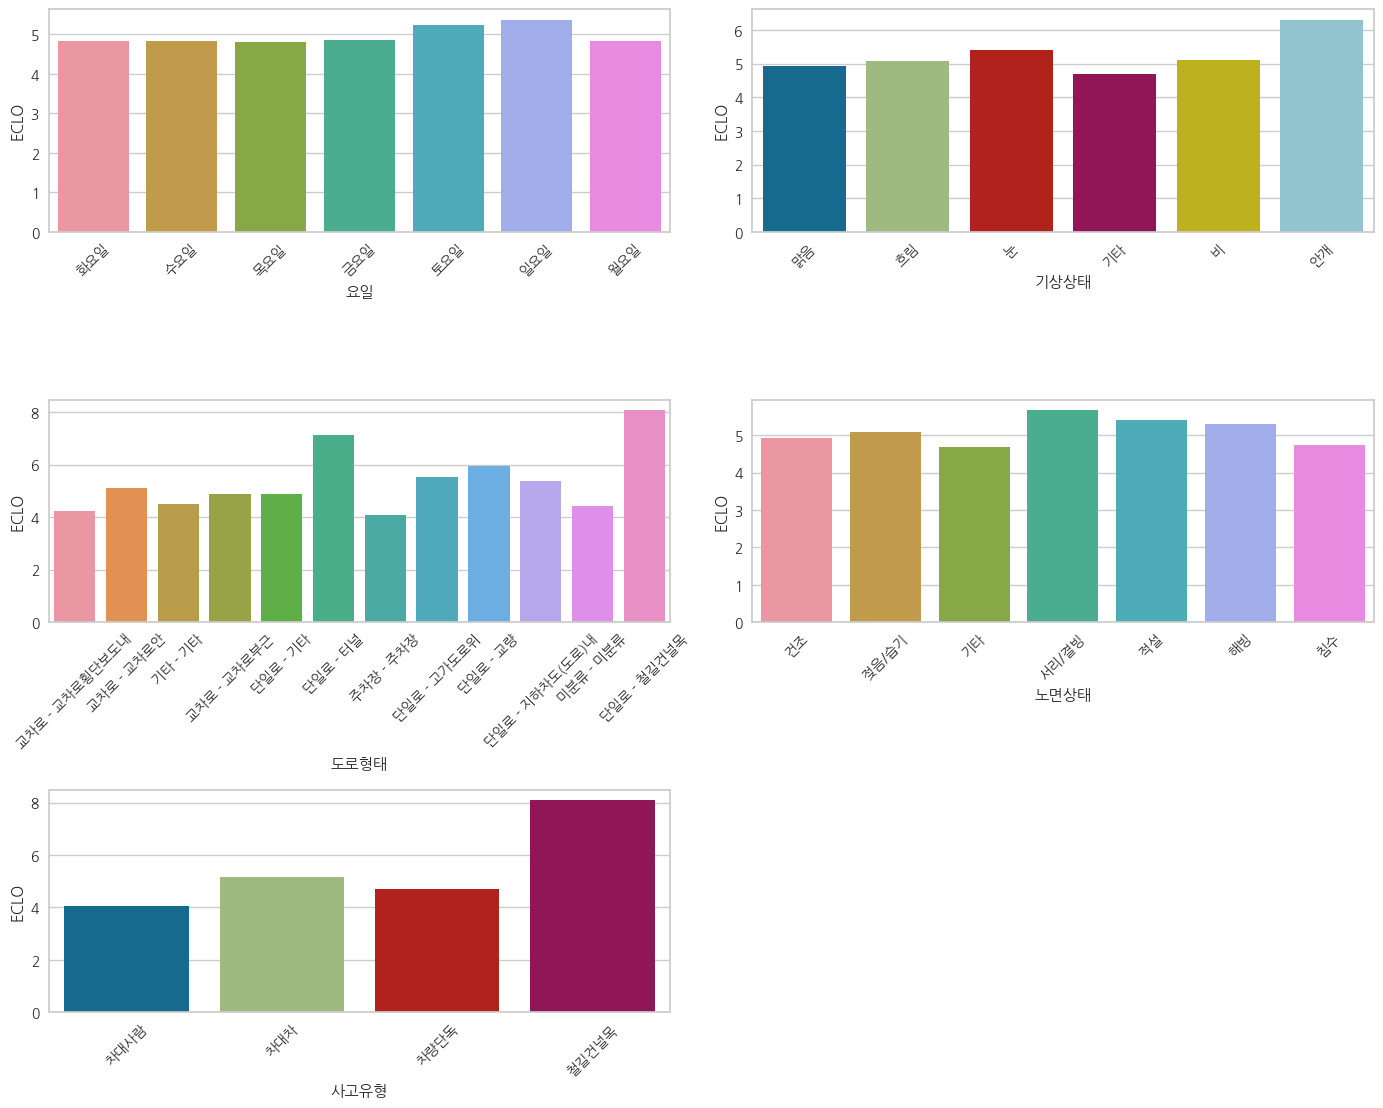

In [13]:
i = 0 
plt.figure(figsize=(14,26))
for col in ['요일',
 '기상상태',
 '도로형태',
 '노면상태',
 '사고유형']:
    i += 1
    plt.subplot(7,2,i)
    sns.barplot(x=country[col], y=country['ECLO'],ci=None)
    plt.xticks(rotation=45)
plt.tight_layout()

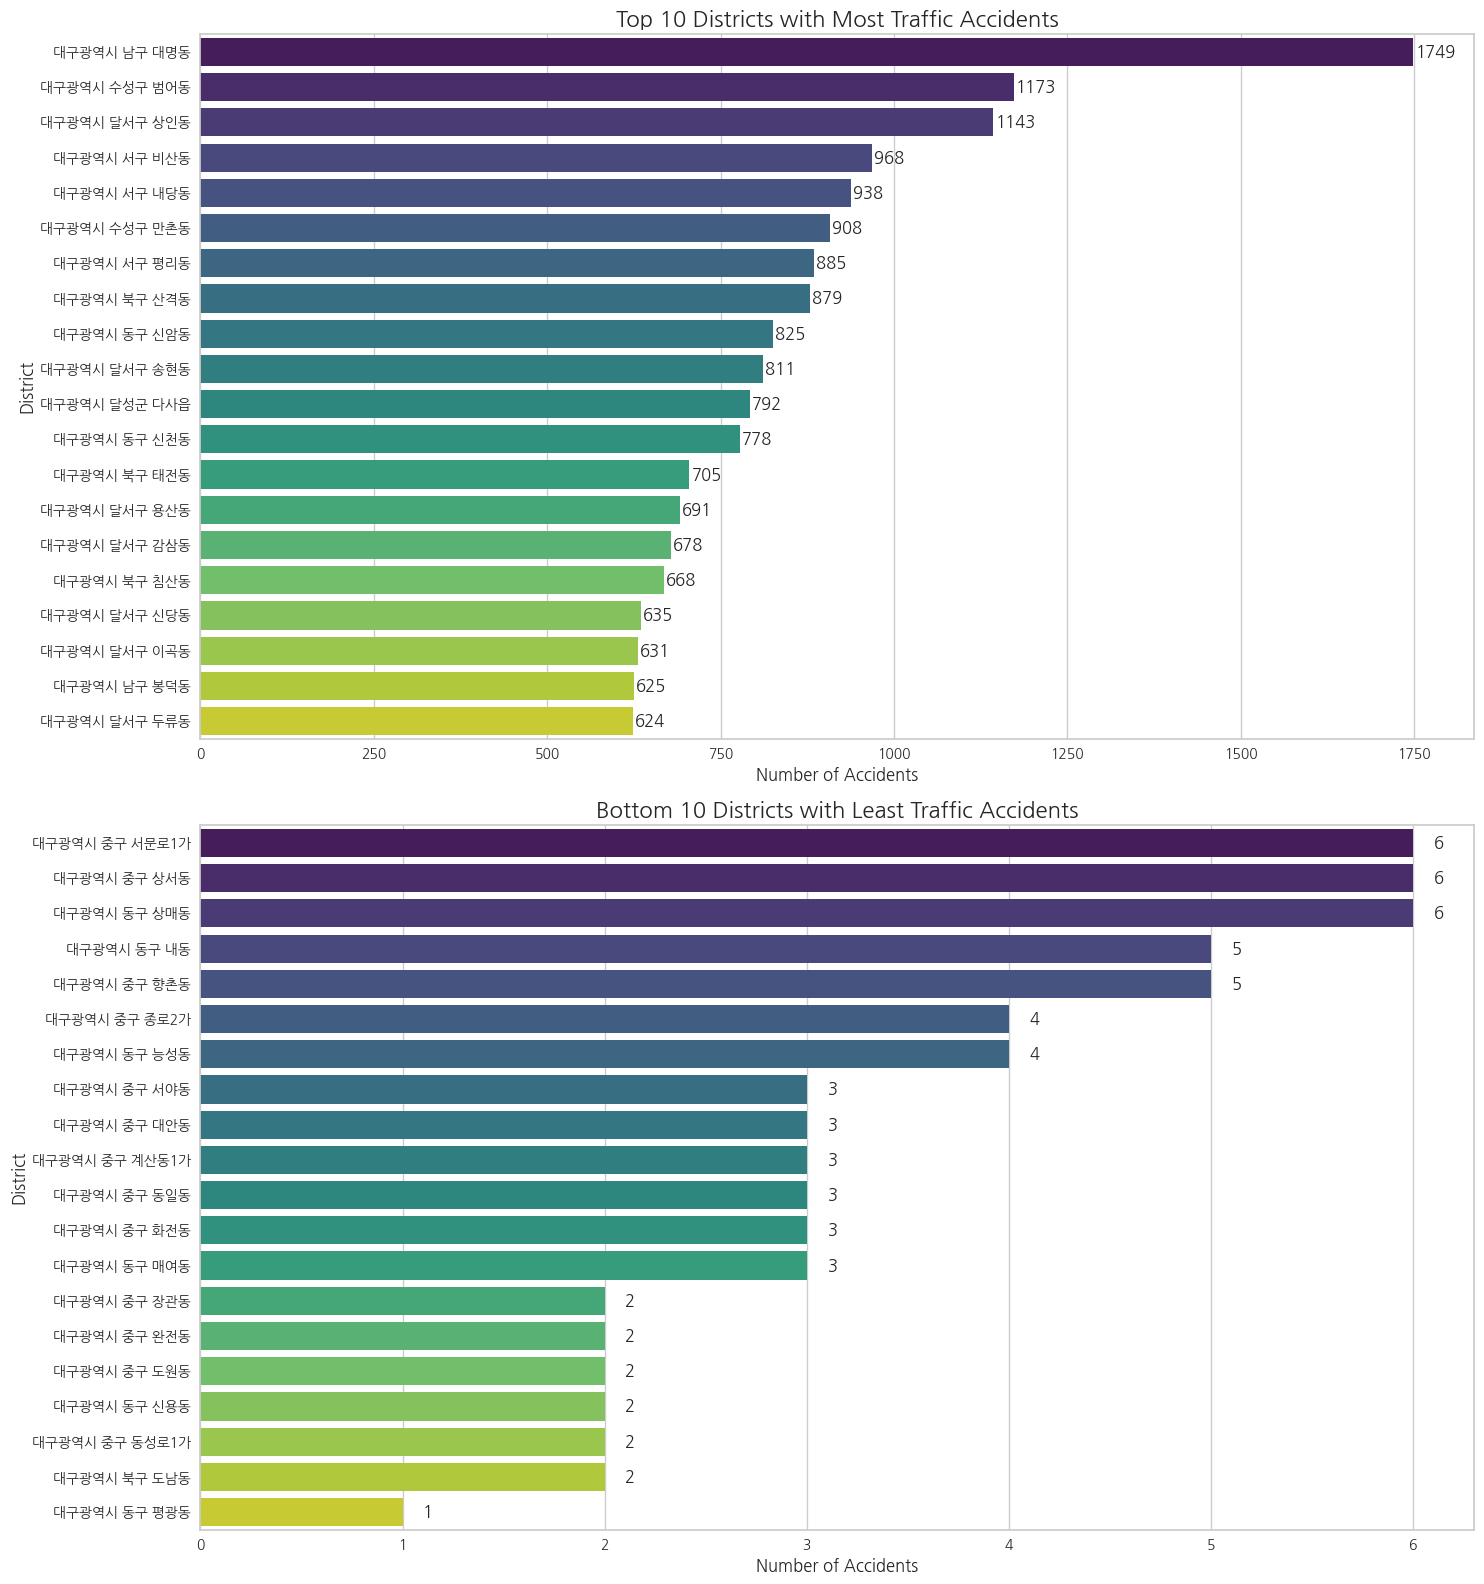

Summary statistics for all districts:
count     199.000000
mean      199.040201
std       272.210626
min         1.000000
25%        18.000000
50%        89.000000
75%       252.500000
max      1749.000000
Name: 시군구, dtype: float64

Total number of unique districts: 199

Top 10 districts with most accidents:
대구광역시 남구 대명동     1749
대구광역시 수성구 범어동    1173
대구광역시 달서구 상인동    1143
대구광역시 서구 비산동      968
대구광역시 서구 내당동      938
대구광역시 수성구 만촌동     908
대구광역시 서구 평리동      885
대구광역시 북구 산격동      879
대구광역시 동구 신암동      825
대구광역시 달서구 송현동     811
대구광역시 달성군 다사읍     792
대구광역시 동구 신천동      778
대구광역시 북구 태전동      705
대구광역시 달서구 용산동     691
대구광역시 달서구 감삼동     678
대구광역시 북구 침산동      668
대구광역시 달서구 신당동     635
대구광역시 달서구 이곡동     631
대구광역시 남구 봉덕동      625
대구광역시 달서구 두류동     624
Name: 시군구, dtype: int64

Bottom 10 districts with least accidents:
대구광역시 중구 서문로1가    6
대구광역시 중구 상서동      6
대구광역시 동구 상매동      6
대구광역시 동구 내동       5
대구광역시 중구 향촌동      5
대구광역시 중구 종로2가     4
대구광역시 동구 능성동      4
대구광역시 중구 서야동      3
대구광역시 중구 대안동      3
대구광

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already loaded your data into a DataFrame called 'train'
# If not, uncomment and modify the following line:
# train = pd.read_csv('your_data_file.csv')

# Count the number of accidents for each district
district_counts = train['시군구'].value_counts()

# Select top 10 and bottom 10 districts
top_10 = district_counts.head(20)
bottom_10 = district_counts.tail(20)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))

# Plot top 10 districts
sns.barplot(x=top_10.values, y=top_10.index, ax=ax1, palette='viridis')
ax1.set_title('Top 10 Districts with Most Traffic Accidents', fontsize=16)
ax1.set_xlabel('Number of Accidents', fontsize=12)
ax1.set_ylabel('District', fontsize=12)

# Add value labels to the end of each bar for top 10
for i, v in enumerate(top_10.values):
    ax1.text(v + 3, i, str(v), va='center')

# Plot bottom 10 districts
sns.barplot(x=bottom_10.values, y=bottom_10.index, ax=ax2, palette='viridis')
ax2.set_title('Bottom 10 Districts with Least Traffic Accidents', fontsize=16)
ax2.set_xlabel('Number of Accidents', fontsize=12)
ax2.set_ylabel('District', fontsize=12)

# Add value labels to the end of each bar for bottom 10
for i, v in enumerate(bottom_10.values):
    ax2.text(v + 0.1, i, str(v), va='center')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary statistics for all districts:")
print(district_counts.describe())

# Print the total number of unique districts
print(f"\nTotal number of unique districts: {len(district_counts)}")

# Print top 10 and bottom 10 districts
print("\nTop 10 districts with most accidents:")
print(top_10)
print("\nBottom 10 districts with least accidents:")
print(bottom_10)

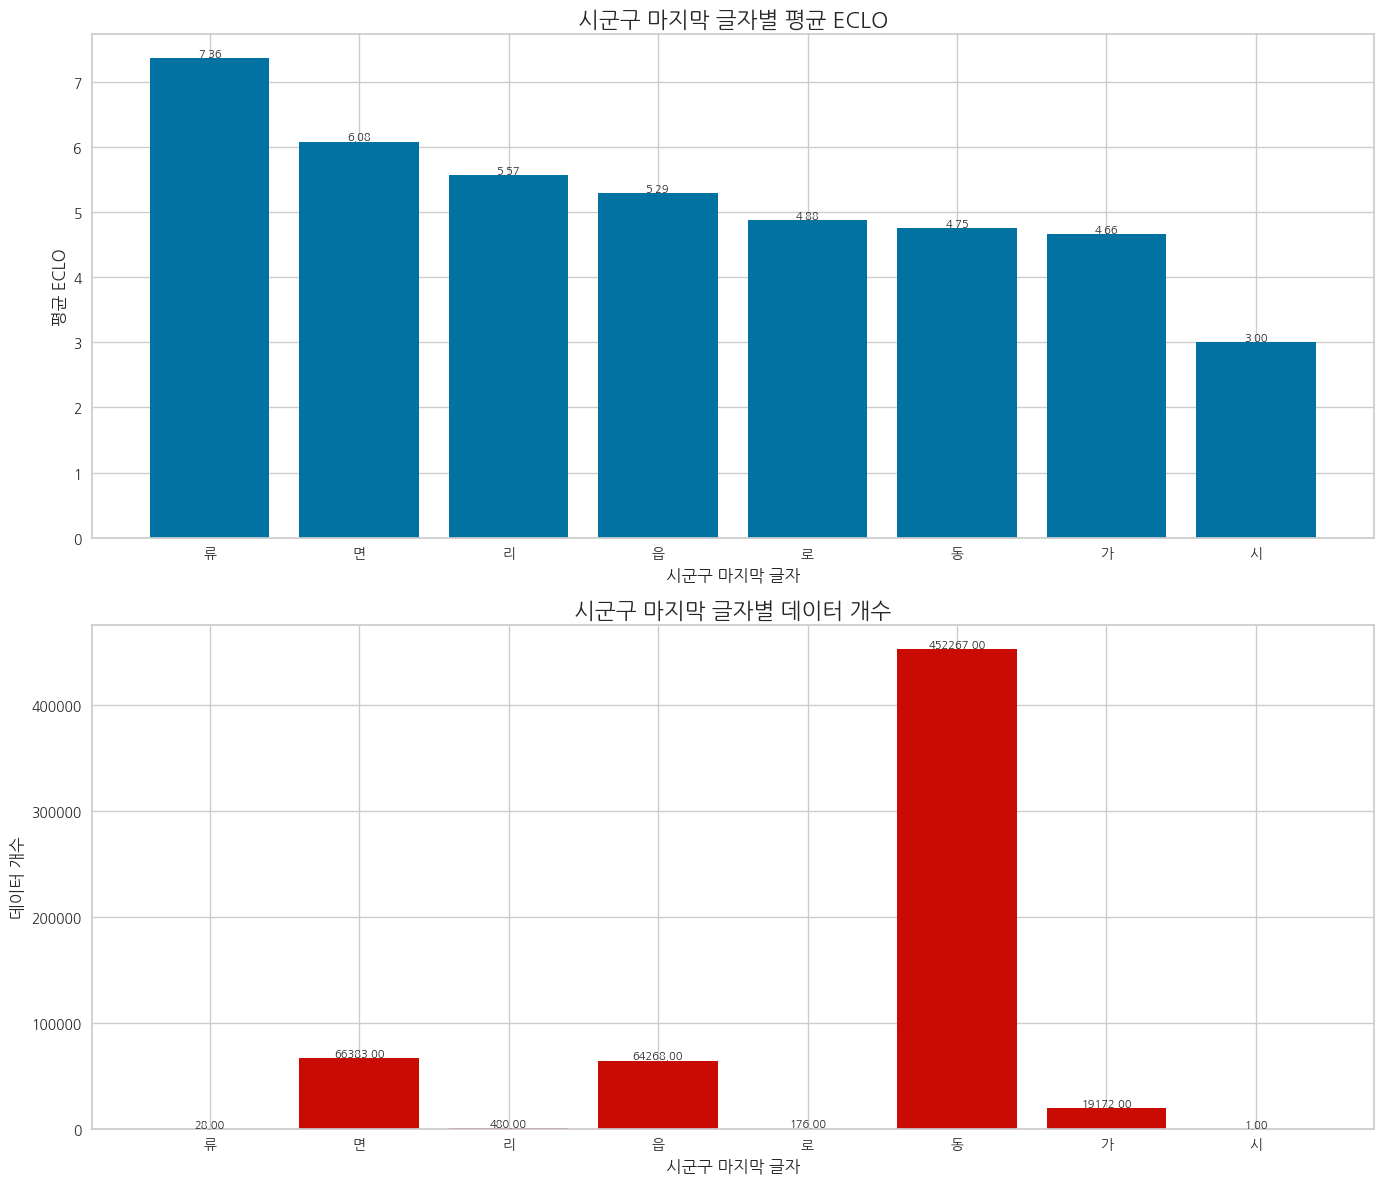

               ECLO     시군구
last_char                  
류          7.357143      28
면          6.078755   66383
리          5.570833     480
읍          5.288946   64268
로          4.875000     176
동          4.745170  452267
가          4.656739   19172
시          3.000000       1


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터가 이미 'train'이라는 DataFrame에 로드되어 있다고 가정합니다.
# 만약 그렇지 않다면, 아래 줄의 주석을 해제하고 파일 경로를 수정하세요.
# train = pd.read_csv('your_data_file.csv')

# '시군구' 컬럼의 마지막 글자를 추출하여 새로운 컬럼 생성
country['last_char'] = country['시군구'].str[-1]

# 마지막 글자를 기준으로 그룹화하고 'ECLO' 컬럼의 평균과 데이터 개수 계산
grouped_data = country.groupby('last_char').agg({
    'ECLO': 'mean',
    '시군구': 'count'  # 데이터 개수를 세기 위해 아무 컬럼이나 사용 가능
}).sort_values('ECLO', ascending=False)

# 그래프 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 평균 ECLO 막대 그래프 (상단 subplot)
bars1 = ax1.bar(grouped_data.index, grouped_data['ECLO'], color='b')
ax1.set_title("시군구 마지막 글자별 평균 ECLO", fontsize=16)
ax1.set_xlabel("시군구 마지막 글자", fontsize=12)
ax1.set_ylabel("평균 ECLO", fontsize=12)

# 데이터 개수 막대 그래프 (하단 subplot)
bars2 = ax2.bar(grouped_data.index, grouped_data['시군구'], color='r')
ax2.set_title("시군구 마지막 글자별 데이터 개수", fontsize=16)
ax2.set_xlabel("시군구 마지막 글자", fontsize=12)
ax2.set_ylabel("데이터 개수", fontsize=12)

# 각 막대 위에 값 표시
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

add_value_labels(ax1, bars1)
add_value_labels(ax2, bars2)

# 그래프 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# 결과 출력
print(grouped_data)

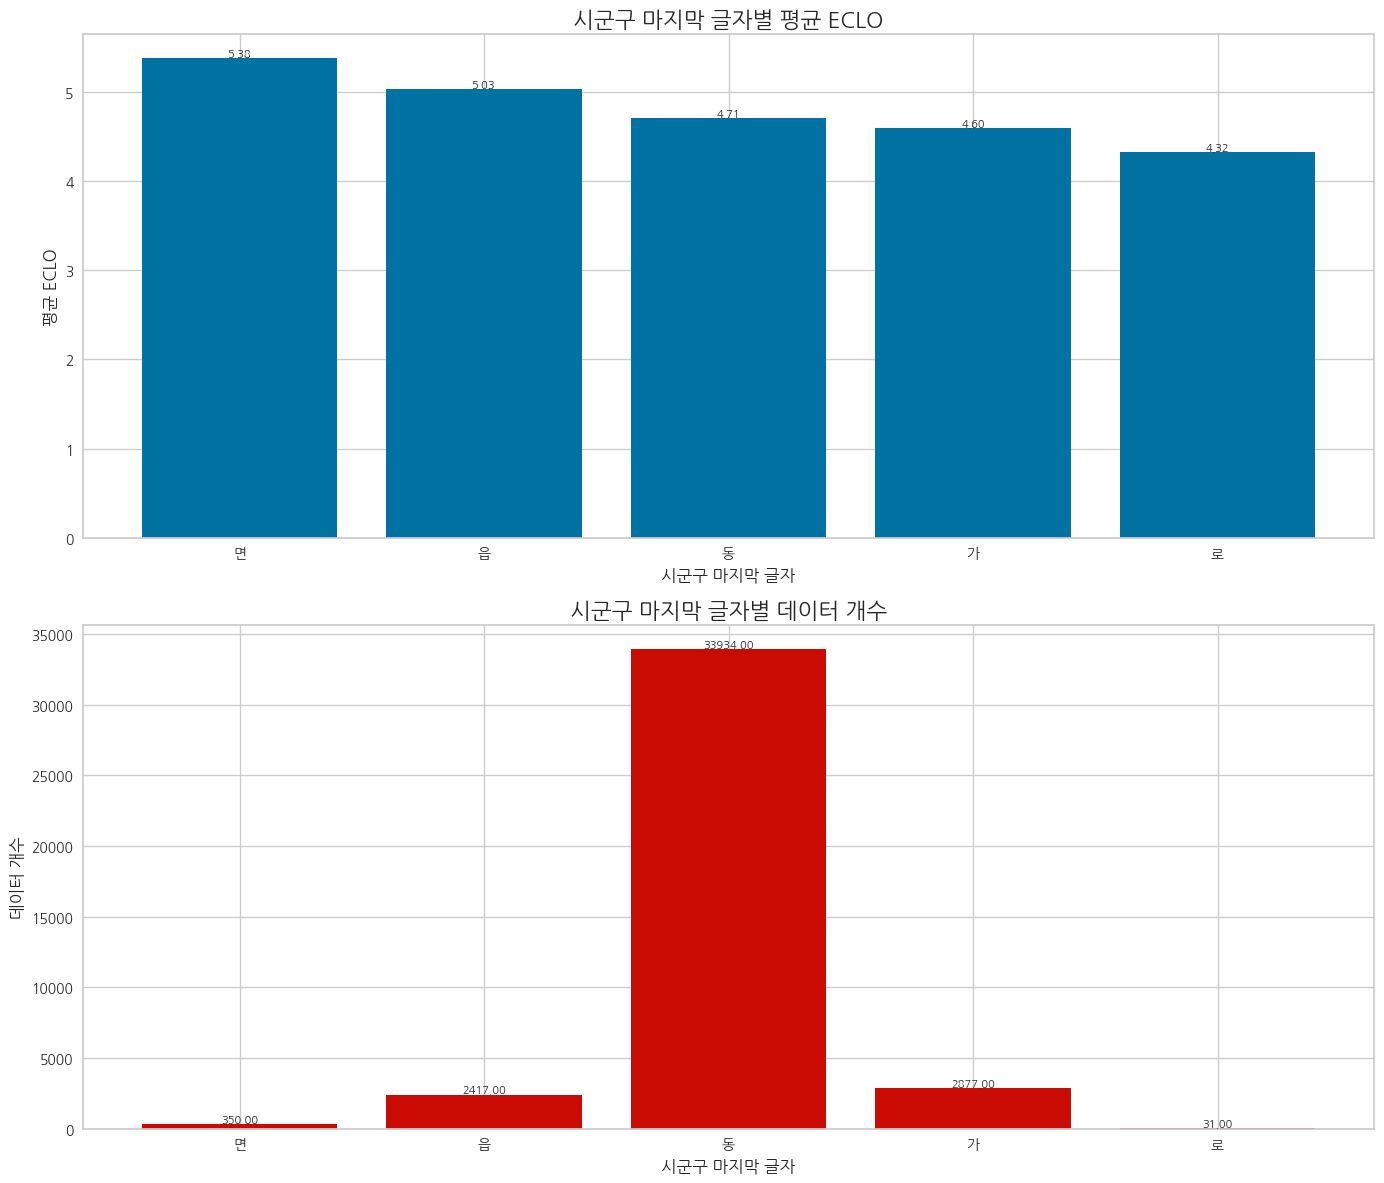

               ECLO    시군구
last_char                 
면          5.377143    350
읍          5.028134   2417
동          4.709937  33934
가          4.596455   2877
로          4.322581     31


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# '시군구' 컬럼의 마지막 글자를 추출하여 새로운 컬럼 생성
train['last_char'] = train['시군구'].str[-1]

# 마지막 글자를 기준으로 그룹화하고 'ECLO' 컬럼의 평균과 데이터 개수 계산
grouped_data = train.groupby('last_char').agg({
    'ECLO': 'mean',
    '시군구': 'count'  # 데이터 개수를 세기 위해 아무 컬럼이나 사용 가능
}).sort_values('ECLO', ascending=False)

# 그래프 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 평균 ECLO 막대 그래프 (상단 subplot)
bars1 = ax1.bar(grouped_data.index, grouped_data['ECLO'], color='b')
ax1.set_title("시군구 마지막 글자별 평균 ECLO", fontsize=16)
ax1.set_xlabel("시군구 마지막 글자", fontsize=12)
ax1.set_ylabel("평균 ECLO", fontsize=12)

# 데이터 개수 막대 그래프 (하단 subplot)
bars2 = ax2.bar(grouped_data.index, grouped_data['시군구'], color='r')
ax2.set_title("시군구 마지막 글자별 데이터 개수", fontsize=16)
ax2.set_xlabel("시군구 마지막 글자", fontsize=12)
ax2.set_ylabel("데이터 개수", fontsize=12)

# 각 막대 위에 값 표시
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

add_value_labels(ax1, bars1)
add_value_labels(ax2, bars2)

# 그래프 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# 결과 출력
print(grouped_data)

## 제한 속도 데이터 활용

In [24]:
CCTV = pd.read_csv('C:/Users/lhsuk/Prediction-of-Traffic-Accident-Victims-in-Daegu/EDA/dataset/external_open/대구 CCTV 정보.csv', encoding='cp949')

In [25]:
CCTV.head()

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
0,주차12,대구광역시,남구,시도,NaN,대명로,3,대구광역시 남구 대명로 162,대구광역시 남구 대명동 903-13,35.838857,128.575418,안지랑네거리1 버스정류장,4,0,NaN,NaN,99.0,2010.0
1,주차13,대구광역시,남구,시도,NaN,봉덕로,3,대구광역시 남구 봉덕로 135,대구광역시 남구 봉덕동 853-8,35.844653,128.604619,효성백년가약,4,0,NaN,NaN,99.0,2013.0
2,주차14,대구광역시,남구,시도,NaN,대봉로,3,대구광역시 남구 봉덕로 134,대구광역시 남구 봉덕동 866-46,35.844183,128.604815,강변코오롱하늘채,4,0,NaN,NaN,99.0,2013.0
3,주차15,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 200,대구광역시 남구 대명동 2680-17,35.834798,128.585284,보성청록타운,4,0,NaN,NaN,99.0,2014.0
4,주차16,대구광역시,남구,시도,NaN,큰골길,3,대구광역시 남구 큰골길 243,대구광역시 남구 봉덕동 1616,35.832728,128.588324,환경차고지,4,0,NaN,NaN,99.0,2014.0


In [49]:
import pandas as pd
import re
import numpy as np

# 주소 파싱 함수
def parse_address(address):
    if pd.isna(address) or not isinstance(address, str):
        return np.nan
    # '광역시/도'를 제외하고 '구 동/읍/면/가' 형태로 파싱
    pattern = r'(?:[\w]+[시도]\s)?([\w]+[구]\s[\w]+[동읍면가])'
    match = re.search(pattern, address)
    if match:
        return match.group(1)
    return address  # 매치되지 않으면 원래 주소 반환

# 주소 파싱
CCTV['파싱된_주소'] = CCTV['소재지지번주소'].apply(parse_address)

# 제한속도가 0인 값 제외
CCTV_filtered = CCTV[CCTV['제한속도'] != 0]

# 파싱된 주소로 그룹화하여 통계 계산
cctv_result = CCTV_filtered.groupby('파싱된_주소').agg({
    '제한속도': ['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None]
}).reset_index()

# 컬럼 이름 설정
cctv_result.columns = ['시군구', '평균_제한속도', '중앙값_제한속도', '최빈값_제한속도']

# NaN 값 제거 (선택사항)
cctv_result = cctv_result.dropna(subset=['시군구'])

print(cctv_result)

# 추가적인 정보 출력
print(f"\n총 CCTV 개수: {len(CCTV)}")
print(f"제한속도 0 제외 후 CCTV 개수: {len(CCTV_filtered)}")
print(f"제거된 CCTV 개수: {len(CCTV) - len(CCTV_filtered)}")

          시군구    평균_제한속도  중앙값_제한속도  최빈값_제한속도
0      남구 대명동  47.037037      50.0        50
1      남구 봉덕동  38.888889      30.0        30
2      남구 성당동  40.000000      40.0        40
3      남구 이천동  40.000000      40.0        30
4     달서구 갈산동  50.000000      50.0        50
..        ...        ...       ...       ...
288  중구 서성로2가  50.000000      50.0        50
289    중구 수창동  40.000000      40.0        40
290    중구 인교동  40.000000      40.0        40
291   중구 종로1가  50.000000      50.0        50
292  중구 태평로3가  50.000000      50.0        50

[293 rows x 4 columns]

총 CCTV 개수: 1065
제한속도 0 제외 후 CCTV 개수: 833
제거된 CCTV 개수: 232


In [53]:
def remove_city_name(address):
    return re.sub(r'^대구광역시\s+', '', address)
result = train.groupby('시군구')['ECLO'].mean().reset_index()

# 결과 정렬 (선택사항)
eclo_data  = result.sort_values('ECLO', ascending=False)

# ECLO 데이터 처리
eclo_data['시군구'] = eclo_data['시군구'].apply(remove_city_name)
eclo_result = eclo_data.groupby('시군구')['ECLO'].mean().reset_index()

# Inner join
final_result = pd.merge(eclo_result, cctv_result, on='시군구', how='inner')

len(final_result)


44

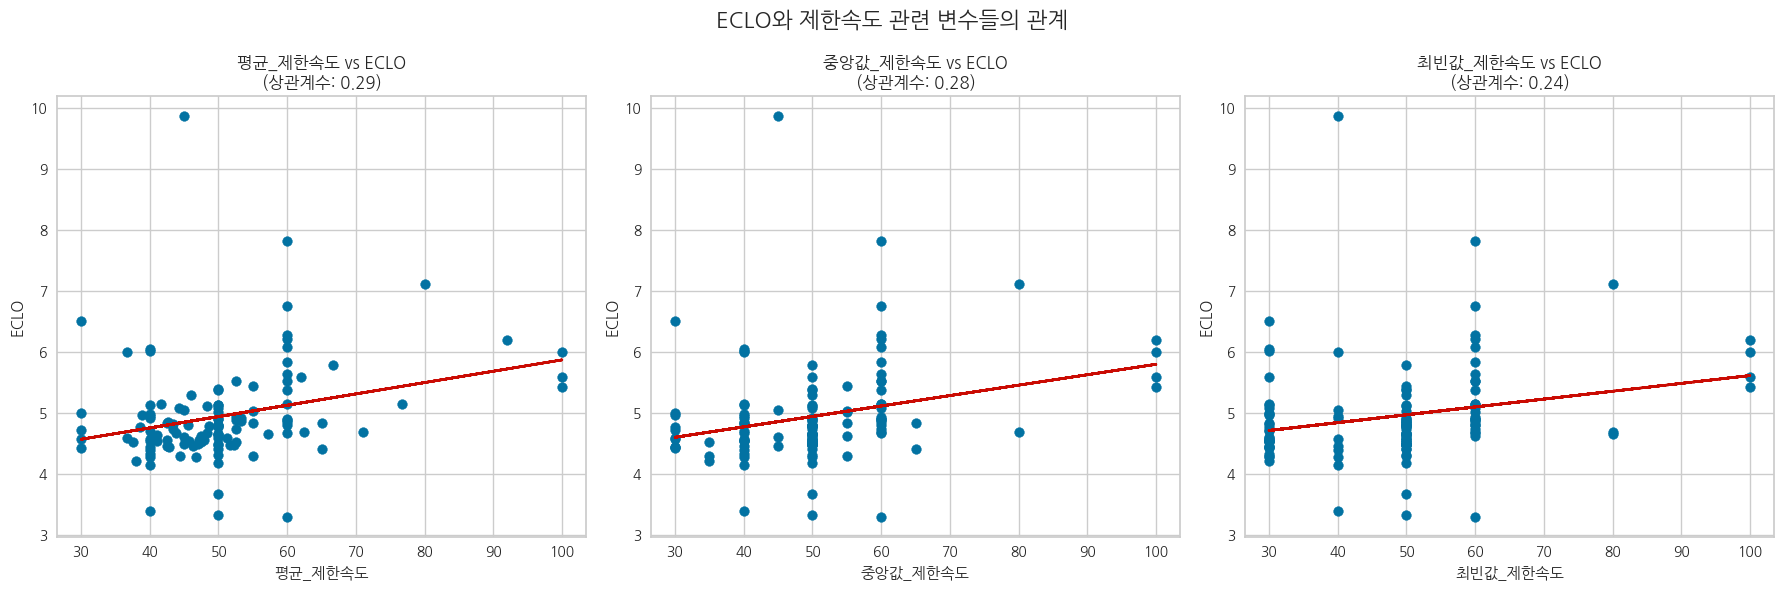

          시군구      ECLO    평균_제한속도  중앙값_제한속도  최빈값_제한속도
0      남구 대명동  4.492281  47.037037      50.0        50
1      남구 봉덕동  4.968000  38.888889      30.0        30
2      남구 이천동  4.702703  40.000000      40.0        30
3     달서구 갈산동  4.909091  50.000000      50.0        50
4     달서구 감삼동  4.738938  52.500000      60.0        60
..        ...       ...        ...       ...       ...
117  중구 서성로2가  3.333333  50.000000      50.0        50
118    중구 수창동  3.392857  40.000000      40.0        40
119    중구 인교동  4.388889  40.000000      40.0        40
120   중구 종로1가  4.416667  50.000000      50.0        50
121  중구 태평로3가  5.125000  50.000000      50.0        50

[122 rows x 5 columns]


In [51]:
from scipy import stats

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('ECLO와 제한속도 관련 변수들의 관계', fontsize=16)

speed_vars = ['평균_제한속도', '중앙값_제한속도', '최빈값_제한속도']

for i, var in enumerate(speed_vars):
    # Scatter plot
    axs[i].scatter(final_result[var], final_result['ECLO'])
    
    # 추세선
    z = np.polyfit(final_result[var], final_result['ECLO'], 1)
    p = np.poly1d(z)
    axs[i].plot(final_result[var], p(final_result[var]), "r--")
    
    # 상관계수 계산
    corr, _ = stats.pearsonr(final_result[var], final_result['ECLO'])
    
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('ECLO')
    axs[i].set_title(f'{var} vs ECLO\n(상관계수: {corr:.2f})')


plt.tight_layout()
plt.show()

print(final_result)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


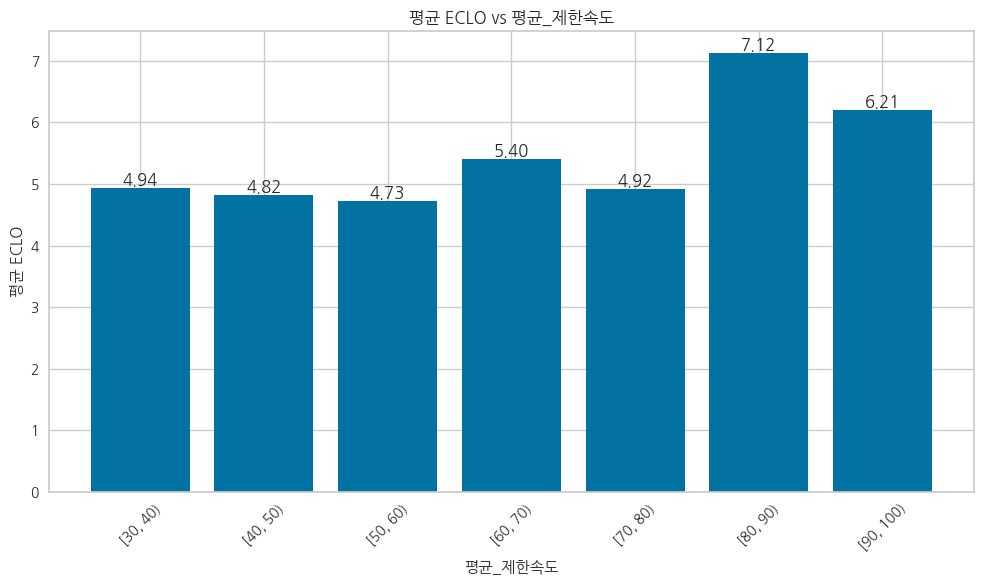

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


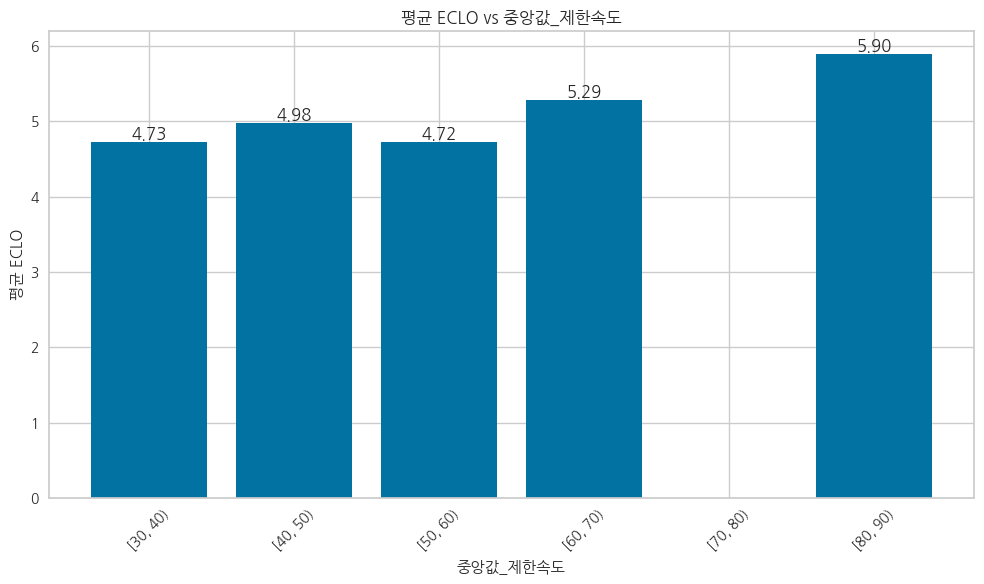

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


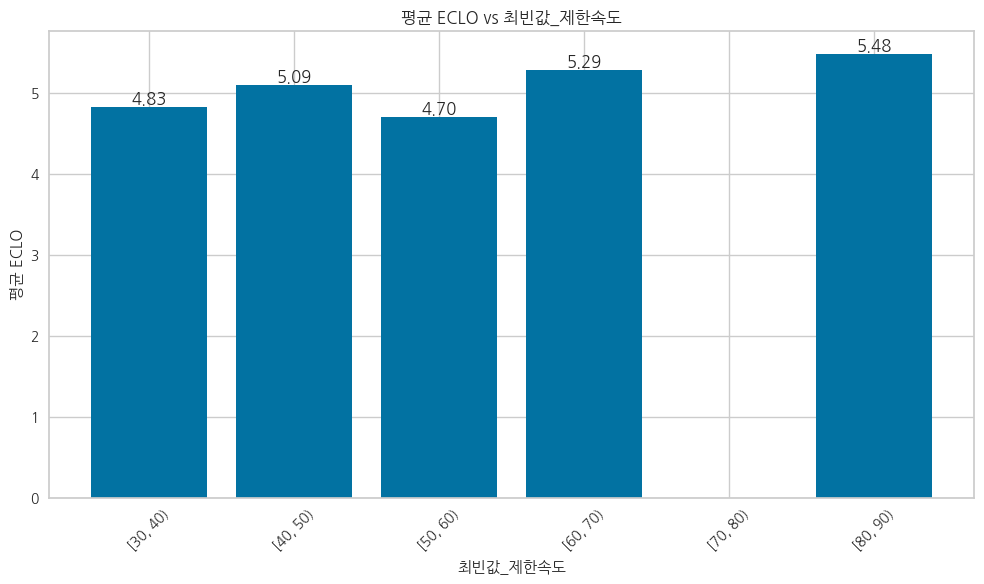

          시군구      ECLO    평균_제한속도  중앙값_제한속도  최빈값_제한속도  x_binned
0      남구 대명동  4.492281  47.037037      50.0        50  [50, 60)
1      남구 봉덕동  4.968000  38.888889      30.0        30  [30, 40)
2      남구 이천동  4.702703  40.000000      40.0        30  [30, 40)
3     달서구 갈산동  4.909091  50.000000      50.0        50  [50, 60)
4     달서구 감삼동  4.738938  52.500000      60.0        60  [60, 70)
..        ...       ...        ...       ...       ...       ...
117  중구 서성로2가  3.333333  50.000000      50.0        50  [50, 60)
118    중구 수창동  3.392857  40.000000      40.0        40  [40, 50)
119    중구 인교동  4.388889  40.000000      40.0        40  [40, 50)
120   중구 종로1가  4.416667  50.000000      50.0        50  [50, 60)
121  중구 태평로3가  5.125000  50.000000      50.0        50  [50, 60)

[122 rows x 6 columns]


In [45]:
def create_barplot(data, x_column, y_column='ECLO'):
    # 10단위로 구간화
    data['x_binned'] = pd.cut(data[x_column], bins=range(0, 101, 10), right=False)
    
    # 구간별 평균 계산
    grouped_data = data.groupby('x_binned')[y_column].mean().reset_index()
    
    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    bars = plt.bar(grouped_data['x_binned'].astype(str), grouped_data[y_column])
    
    # 바 위에 값 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')
    
    plt.title(f'평균 ECLO vs {x_column}')
    plt.xlabel(x_column)
    plt.ylabel('평균 ECLO')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 각 제한속도 관련 변수에 대해 barplot 생성
for column in ['평균_제한속도', '중앙값_제한속도', '최빈값_제한속도']:
    create_barplot(final_result, column)

print(final_result)

In [52]:
import pandas as pd
import re
import numpy as np

# 주소 파싱 함수
def parse_address(address):
    if pd.isna(address) or not isinstance(address, str):
        return np.nan
    # '광역시/도'를 제외하고 '구 동/읍/면/가' 형태로 파싱
    pattern = r'(?:[\w]+[시도]\s)?([\w]+[구]\s[\w]+[동읍면가])'
    match = re.search(pattern, address)
    if match:
        return match.group(1)
    return address  # 매치되지 않으면 원래 주소 반환

# 주소 파싱
CCTV['파싱된_주소'] = CCTV['소재지지번주소'].apply(parse_address)

# 제한속도가 0인 값 제외
CCTV_filtered = CCTV[CCTV['제한속도'] != 0]

# 각 지역의 데이터 포인트 수 계산
region_counts = CCTV_filtered['파싱된_주소'].value_counts()

# 데이터 포인트가 5개 이상인 지역만 선택
CCTV_filtered = CCTV_filtered[CCTV_filtered['파싱된_주소'].isin(region_counts[region_counts >= 5].index)]

# 파싱된 주소로 그룹화하여 통계 계산
cctv_result = CCTV_filtered.groupby('파싱된_주소').agg({
    '제한속도': ['mean', 'median', lambda x: x.mode().iloc[0] if not x.mode().empty else None]
}).reset_index()

# 컬럼 이름 설정
cctv_result.columns = ['시군구', '평균_제한속도', '중앙값_제한속도', '최빈값_제한속도']

# NaN 값 제거 (선택사항)
cctv_result = cctv_result.dropna(subset=['시군구'])

print(cctv_result)

# 추가적인 정보 출력
print(f"\n총 CCTV 개수: {len(CCTV)}")
print(f"제한속도 0 제외 후 CCTV 개수: {len(CCTV[CCTV['제한속도'] != 0])}")
print(f"5개 이상 데이터 포인트 지역의 CCTV 개수: {len(CCTV_filtered)}")
print(f"제거된 CCTV 개수 (제한속도 0 및 5개 미만 데이터 포인트): {len(CCTV) - len(CCTV_filtered)}")
print(f"분석에 포함된 지역 수: {len(cctv_result)}")

        시군구    평균_제한속도  중앙값_제한속도  최빈값_제한속도
0    남구 대명동  47.037037      50.0        50
1    남구 봉덕동  38.888889      30.0        30
2   달서구 대곡동  45.555556      50.0        50
3   달서구 도원동  57.142857      50.0        80
4   달서구 두류동  52.500000      50.0        50
5    달서구 본동  43.333333      40.0        30
6   달서구 본리동  46.250000      45.0        40
7   달서구 상인동  44.444444      35.0        30
8   달서구 송현동  40.000000      30.0        30
9   달서구 신당동  45.714286      50.0        30
10  달서구 용산동  42.666667      40.0        50
11  달서구 월성동  41.111111      50.0        50
12  달서구 유천동  48.333333      50.0        50
13  달서구 이곡동  41.000000      40.0        30
14  달서구 장기동  38.571429      30.0        30
15  달서구 호산동  45.000000      45.0        30
16   동구 신암동  40.000000      40.0        30
17   동구 신천동  50.000000      50.0        50
18   동구 신평동  92.000000     100.0       100
19   동구 율하동  50.000000      50.0        50
20   동구 지묘동  46.000000      50.0        50
21   북구 구암동  40.000000      40.0        30
22   북구 국우동

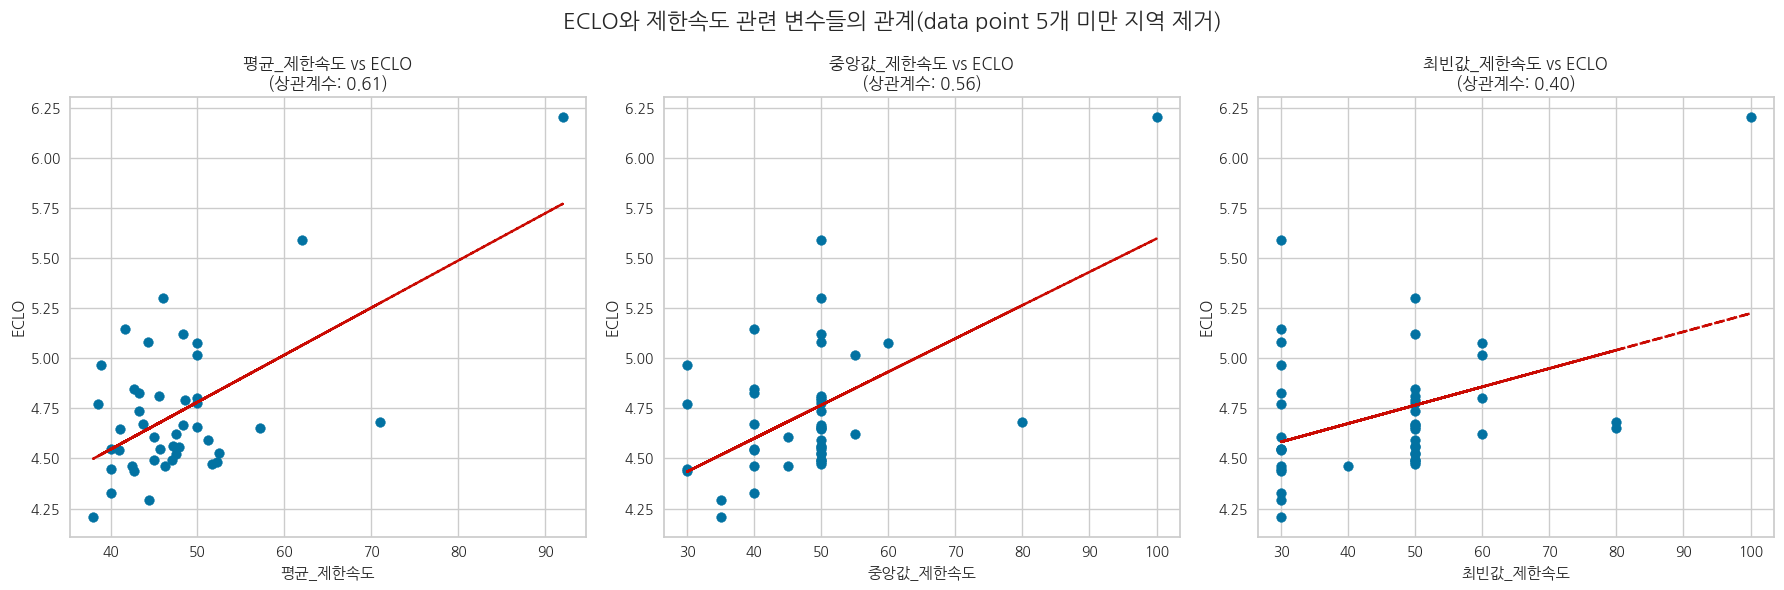

        시군구      ECLO    평균_제한속도  중앙값_제한속도  최빈값_제한속도
0    남구 대명동  4.492281  47.037037      50.0        50
1    남구 봉덕동  4.968000  38.888889      30.0        30
2   달서구 대곡동  4.812057  45.555556      50.0        50
3   달서구 도원동  4.650862  57.142857      50.0        80
4   달서구 두류동  4.527244  52.500000      50.0        50
5    달서구 본동  4.824713  43.333333      40.0        30
6   달서구 본리동  4.464548  46.250000      45.0        40
7   달서구 상인동  4.293963  44.444444      35.0        30
8   달서구 송현동  4.448829  40.000000      30.0        30
9   달서구 신당동  4.546457  45.714286      50.0        30
10  달서구 용산동  4.846599  42.666667      40.0        50
11  달서구 월성동  4.648867  41.111111      50.0        50
12  달서구 유천동  4.668394  48.333333      50.0        50
13  달서구 이곡동  4.540412  41.000000      40.0        30
14  달서구 장기동  4.773519  38.571429      30.0        30
15  달서구 호산동  4.606218  45.000000      45.0        30
16   동구 신암동  4.549091  40.000000      40.0        30
17   동구 신천동  4.655527  50.000000      50.0    

In [56]:
from scipy import stats

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('ECLO와 제한속도 관련 변수들의 관계(data point 5개 미만 지역 제거)', fontsize=16)

speed_vars = ['평균_제한속도', '중앙값_제한속도', '최빈값_제한속도']

for i, var in enumerate(speed_vars):
    # Scatter plot
    axs[i].scatter(final_result[var], final_result['ECLO'])
    
    # 추세선
    z = np.polyfit(final_result[var], final_result['ECLO'], 1)
    p = np.poly1d(z)
    axs[i].plot(final_result[var], p(final_result[var]), "r--")
    
    # 상관계수 계산
    corr, _ = stats.pearsonr(final_result[var], final_result['ECLO'])
    
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('ECLO')
    axs[i].set_title(f'{var} vs ECLO\n(상관계수: {corr:.2f})')


plt.tight_layout()
plt.show()

print(final_result)